Goal: To predict The Salary Based on some of the Factors of the Job Position

In [532]:
import glassdoor_scraper as gs


import pandas as pd

import sys

import re

import matplotlib.pyplot as plt

import plotly.express as px

import numpy as np

import scipy

import sklearn

import seaborn as sns

from datetime import datetime, timedelta

from matplotlib import dates as mpl_dates

from matplotlib.animation import FuncAnimation

# 1. Scrapping Data

In [533]:
path = "C:/Users/enriq/Anaconda3/Lib/site-packages/selenium/webdriver/chrome/chromedriver.exe"

In [534]:
# df=gs.get_jobs("data scientist", 12, False, path, 15) # didnt work for me 

In [535]:
df = pd.read_csv(r"C:\Users\enriq\Your_env_name_Notebooks\Github_Project_Ken\glassdoor_datascience_US.csv", engine="python", encoding='utf-8', error_bad_lines=False)

Skipping line 753: unexpected end of data


# 2. Data cleaning

In [536]:
pd.set_option("display.max_rows", 85)

In [537]:
pd.set_option("display.max_columns", 40)

In [538]:
df.dtypes

Unnamed: 0             int64
Job Title             object
Salary Estimate       object
Job Description       object
Rating               float64
Company Name          object
Location              object
Headquarters          object
Size                  object
Founded                int64
Type of ownership     object
Industry              object
Sector                object
Revenue               object
Competitors           object
dtype: object

In [539]:
df.columns = df.columns.str.lower() # Making title columns lower case

In [540]:
filt = df["salary estimate"].str.contains("Per Hour")

In [541]:
df["salary estimate"].loc[filt]

197             $17-$24 Per Hour(Glassdoor est.)
209             $21-$34 Per Hour(Glassdoor est.)
240             $18-$25 Per Hour(Glassdoor est.)
247             $21-$34 Per Hour(Glassdoor est.)
257             $15-$25 Per Hour(Glassdoor est.)
307             $17-$24 Per Hour(Glassdoor est.)
337             $21-$34 Per Hour(Glassdoor est.)
427             $18-$25 Per Hour(Glassdoor est.)
437             $24-$39 Per Hour(Glassdoor est.)
456             $21-$34 Per Hour(Glassdoor est.)
464    Employer Provided Salary:$25-$28 Per Hour
522             $21-$29 Per Hour(Glassdoor est.)
523             $10-$17 Per Hour(Glassdoor est.)
632             $18-$25 Per Hour(Glassdoor est.)
652             $24-$39 Per Hour(Glassdoor est.)
682             $21-$34 Per Hour(Glassdoor est.)
694    Employer Provided Salary:$25-$28 Per Hour
Name: salary estimate, dtype: object

In [542]:
df["hourly"] = filt

In [543]:
pattern = re.compile(r"[\d{2}]+")

In [544]:
lista = [] # salary parsing
for i in df["salary estimate"]:
    x = pattern.findall(i)
    if x[0] != 1 and len(x) > 1:
        try:
            x[0] = int(x[0])
            x[1] = int(x[1])
            x=pd.Series(x).mean()
        except IndexError:
            pass
    elif x[0]==1:
        x=np.nan
    else:
        x=int(x[0])
    lista.append(x)


In [545]:
df["salary_average"] = pd.Series(lista)

In [546]:
df["salary_average"].replace(1, np.nan, inplace=True)

In [547]:
lista2 = [] # salary parsing
for i in df["salary estimate"]:
    x = pattern.findall(i)
    if x[0] != 1:
        try:
            x = int(x[0])
        except IndexError:
            pass
    elif x[0] ==1:
        x=np.nan
    
    lista2.append(x)

In [548]:
df["salary_min"] = pd.Series(lista2)

In [549]:
df["salary_min"].replace(1, np.nan, inplace=True)

In [550]:
lista3 = [] # salary parsing
for i in df["salary estimate"]:
    x = pattern.findall(i)
    if x[0] != 1:
        try:
            x = int(x[0])
        except IndexError:
            pass
    elif x[0] ==1:
        x=np.nan
    
    lista3.append(x)

In [551]:
df["salary_max"] = pd.Series(lista3)

In [552]:
df["salary_max"].replace(1, np.nan, inplace=True)

In [553]:
df_splitted = df["location"].str.split(",", expand=True) # city/state columns

In [554]:
df = pd.concat([df, df_splitted], axis=1)

In [555]:
df = df.drop(["location",2], axis=1)

In [556]:
df.rename(columns={0:"city", 1: "state"}, inplace=True)

In [557]:
df.head()

,unnamed: 0,job title,salary estimate,job description,rating,company name,headquarters,size,founded,type of ownership,industry,sector,revenue,competitors,hourly,salary_average,salary_min,salary_max,city,state
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\r\nLocation: Albuquerque, NM\r\...",3.8,Tecolote Research\r\n3.8,"Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1,False,72.0,53.0,53.0,Albuquerque,NM
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\r\n\r\nI. General Summary\r\...,3.4,University of Maryland Medical System\r\n3.4,"Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,False,87.5,63.0,63.0,Linthicum,MD
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\r\n4.8,"Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1,False,85.0,80.0,80.0,Clearwater,FL
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\r\nJob ID: 310709\r...,3.8,PNNL\r\n3.8,"Richland, WA",1001 to 5000 employees,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa...",False,76.5,56.0,56.0,Richland,WA
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\r\nAffinity Solutions / Marketi...,2.9,Affinity Solutions\r\n2.9,"New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee",False,114.5,86.0,86.0,New York,NY


In [558]:
pattern2 = re.compile(r"\d*\.?\d+") # pattern to parse a decimal number from within a string

In [559]:
pattern2.findall(df["company name"][0])

['3.8']

In [560]:
lista4=[]
for i in df["company name"]:
    x = pattern2.findall(i)
    lista4.append(x)


In [561]:
lista4 = pd.Series(lista4)

In [562]:
lista4 = lista4.astype(str).str.replace("]","").str.replace("[","").str.replace("'","")

In [563]:
lista5 = [] # parsing decimal number from company column
for i in lista4:
    if len(i)==3:
        i = float(i)
        lista5.append(i)
    else:
        lista5.append(i)

In [564]:
lista5 = pd.Series(lista5)

In [565]:
df["parsed_num"] = lista5

In [566]:
lista6 = [] # changing to datetime if format allows it. Otherwise, dont change anything
for i in range(len(df["founded"])):
    try:
        x=pd.to_datetime(df["founded"][i], format="%Y")
        lista6.append(x)
    except ValueError:
        lista6.append(df["founded"][i])

In [567]:
len(lista6)

751

In [568]:
lista7 = [] # Now we obtain the delta times. we had to deal with few -1 values
for i in lista6:
    if i != -1:
        x=round((datetime.now()-i).days/365)
        lista7.append(x)
    else:
        lista7.append(i)

In [569]:
df["years_old"] = pd.Series(lista7)

In [570]:
df["years_old"].replace(-1,np.nan, inplace=True) # converting those -1 values into nan

In [571]:
df["salary_average"].isna().sum()

160

In [572]:
df.head()

,unnamed: 0,job title,salary estimate,job description,rating,company name,headquarters,size,founded,type of ownership,industry,sector,revenue,competitors,hourly,salary_average,salary_min,salary_max,city,state,parsed_num,years_old
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\r\nLocation: Albuquerque, NM\r\...",3.8,Tecolote Research\r\n3.8,"Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1,False,72.0,53.0,53.0,Albuquerque,NM,3.8,47.0
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\r\n\r\nI. General Summary\r\...,3.4,University of Maryland Medical System\r\n3.4,"Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,False,87.5,63.0,63.0,Linthicum,MD,3.4,36.0
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\r\n4.8,"Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1,False,85.0,80.0,80.0,Clearwater,FL,"4, 4.8",10.0
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\r\nJob ID: 310709\r...,3.8,PNNL\r\n3.8,"Richland, WA",1001 to 5000 employees,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa...",False,76.5,56.0,56.0,Richland,WA,3.8,55.0
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\r\nAffinity Solutions / Marketi...,2.9,Affinity Solutions\r\n2.9,"New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee",False,114.5,86.0,86.0,New York,NY,2.9,22.0


In [573]:
df["company_txt"] = df.apply(lambda x: x["company name"].replace("\n","").replace("\r", "") if x["rating"]<0 else x["company name"][:-3].replace("\n","").replace("\r", ""), axis=1)

In [574]:
df

,unnamed: 0,job title,salary estimate,job description,rating,company name,headquarters,size,founded,type of ownership,industry,sector,revenue,competitors,hourly,salary_average,salary_min,salary_max,city,state,parsed_num,years_old,company_txt
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\r\nLocation: Albuquerque, NM\r\...",3.8,Tecolote Research\r\n3.8,"Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1,False,72.0,53.0,53.0,Albuquerque,NM,3.8,47.0,Tecolote Research
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\r\n\r\nI. General Summary\r\...,3.4,University of Maryland Medical System\r\n3.4,"Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,False,87.5,63.0,63.0,Linthicum,MD,3.4,36.0,University of Maryland Medical System
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\r\n4.8,"Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1,False,85.0,80.0,80.0,Clearwater,FL,"4, 4.8",10.0,KnowBe4
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\r\nJob ID: 310709\r...,3.8,PNNL\r\n3.8,"Richland, WA",1001 to 5000 employees,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa...",False,76.5,56.0,56.0,Richland,WA,3.8,55.0,PNNL
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\r\nAffinity Solutions / Marketi...,2.9,Affinity Solutions\r\n2.9,"New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee",False,114.5,86.0,86.0,New York,NY,2.9,22.0,Affinity Solutions
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,746,"Technology-Minded, Data Professional Opportuni...",$40K-$101K (Glassdoor est.),"At VU, we help Veterans buy homes. To make tha...",4.7,Veterans United Home Loans\r\n4.7,"Columbia, MO",1001 to 5000 employees,2002,Company - Private,Lending,Finance,Unknown / Non-Applicable,-1,False,70.5,40.0,40.0,Columbia,MO,4.7,18.0,Veterans United Home Loans
747,747,Big Data Engineer,$84K-$153K (Glassdoor est.),Overview\r\n\r\n\r\nTechnology is constantly c...,3.3,Peraton\r\n3.3,"Herndon, VA",1001 to 5000 employees,2017,Company - Private,Aerospace & Defense,Aerospace & Defense,$1 to $2 billion (USD),-1,False,118.5,84.0,84.0,Chantilly,VA,3.3,3.0,Peraton
748,748,Salesforce Analytics Consultant,$52K-$81K (Glassdoor est.),"Wave6, an Emtec company, innovates with cuttin...",3.9,"Emtec, Inc.\r\n3.9","Jacksonville, FL",501 to 1000 employees,1995,Company - Private,Enterprise Software & Network Solutions,Information Technology,$100 to $500 million (USD),-1,False,66.5,52.0,52.0,Chicago,IL,3.9,25.0,"Emtec, Inc."
749,749,Managing Data Scientist/ML Engineer,$81K-$134K (Glassdoor est.),Managing Data Scientist/ML Engineer\r\n\r\nApp...,3.4,PA Consulting\r\n3.4,"London, United Kingdom",1001 to 5000 employees,1943,Company - Private,Consulting,Business Services,$100 to $500 million (USD),"McKinsey & Company, Accenture, Deloitte",False,107.5,81.0,81.0,Boston,MA,3.4,77.0,PA Consulting


In [575]:
df["python"] = df["job description"].apply(lambda x: True if "python" in x.lower() else False)

In [576]:
df["R studio"] = df["job description"].apply(lambda x: True if " R " in x or "r-studio" in x.lower() else False)

In [577]:
df["spark"] = df["job description"].apply(lambda x: True if "spark" in x.lower() else False)

In [578]:
df["aws"] = df["job description"].apply(lambda x: True if "aws" in x.lower() else False)

In [579]:
df["excell"] = df["job description"].apply(lambda x: True if "excell" in x.lower() else False)

In [580]:
df["SQL"] = df["job description"].apply(lambda x: True if "sql" in x.lower() else False)

In [581]:
df["SQL"].value_counts()

True     385
False    366
Name: SQL, dtype: int64

In [582]:
lista_sql = pd.Series([True if "SQL" in df["job description"][i] else False for i in range(len(df["job description"]))]) # list comprehension with else statement 

In [583]:
lista_sql.value_counts()

True     385
False    366
dtype: int64

In [584]:
df = df.drop("unnamed: 0", axis=1)

In [585]:
# lets create a function that help us to generate a column with job positions
# grouped in 7 different categories

def title_categorizer(title):
    if "data scientist" in title.lower():
        return "data scientist"
    elif "data engineer" in title.lower():
        return "data engineer"
    elif "analyst" in title.lower():
        return "analyst"
    elif "machine learning" in title.lower():
        return "ML"
    elif "manager" in title.lower():
        return "manager"
    elif "director" in title.lower():
        return "director"
    else:
        return np.nan

In [586]:
# we will also create a function to categorise the level of experience of the positions
# This is how we can parse specific info from a column
def experience(title):
    if "sr" in title.lower() or "senior" in title.lower() or "lead" in title.lower()  or "manager" in title.lower()  or "principal" in title.lower() or "chief" in title.lower():
        return "senior"
    elif "jr" in title.lower() or "junior" in title.lower():
        return "junior"
    else:
        return np.nan

In [587]:
df["title_category"] = df["job title"].apply(title_categorizer)

In [588]:
df["title_category"].value_counts(dropna=False)

data scientist    295
NaN               178
data engineer     125
analyst            99
manager            24
ML                 20
director           10
Name: title_category, dtype: int64

In [589]:
df["experience_level"] = df["job title"].apply(experience)

In [590]:
df["experience_level"].value_counts(dropna=False)

NaN       520
senior    229
junior      2
Name: experience_level, dtype: int64

In [591]:
df["state"] = df["state"].str.replace("Los Angeles", "CA") # Replacing Los Angeles for LA because there was one Los Angeles instead of LA
df["state"] = df["state"].str.strip() # this will remove white spaces in the column

In [592]:
df.columns = df.columns.str.replace(" ", "_") # Lets remove spaces and replace them with _ for consistancy

In [593]:
# also lets create a new column with the len of the description since it can be an interesting parameter
df["description_len"] = df["job_description"].str.len()

In [594]:
# Create a column with the number of competitors
df["compet_nums"] = df["competitors"].apply(lambda x: len(x.split(",")) if x != "-1" else 0)

In [595]:
df.columns

Index(['job_title', 'salary_estimate', 'job_description', 'rating',
       'company_name', 'headquarters', 'size', 'founded', 'type_of_ownership',
       'industry', 'sector', 'revenue', 'competitors', 'hourly',
       'salary_average', 'salary_min', 'salary_max', 'city', 'state',
       'parsed_num', 'years_old', 'company_txt', 'python', 'R_studio', 'spark',
       'aws', 'excell', 'SQL', 'title_category', 'experience_level',
       'description_len', 'compet_nums'],
      dtype='object')

In [596]:
# another thing that we should do it to recalculate the hourly salaries to annual.
# We can do this as follows
df["salary_min"] = df.apply(lambda x: x["salary_min"]*2 if x["hourly"] == 1 else x["salary_min"], axis=1)
df["salary_max"] = df.apply(lambda x: x["salary_max"]*2 if x["hourly"] == 1 else x["salary_max"], axis=1)

In [597]:
df.loc[df["hourly"]==1,["hourly", "salary_min", "salary_max"]] # We just check if min < max after this adjustment

,hourly,salary_min,salary_max
197,True,34.0,34.0
209,True,42.0,42.0
240,True,36.0,36.0
247,True,42.0,42.0
257,True,30.0,30.0
307,True,34.0,34.0
337,True,42.0,42.0
427,True,36.0,36.0
437,True,48.0,48.0
456,True,42.0,42.0


In [598]:
df.head()

,job_title,salary_estimate,job_description,rating,company_name,headquarters,size,founded,type_of_ownership,industry,sector,revenue,competitors,hourly,salary_average,salary_min,salary_max,city,state,parsed_num,years_old,company_txt,python,R_studio,spark,aws,excell,SQL,title_category,experience_level,description_len,compet_nums
0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\r\nLocation: Albuquerque, NM\r\...",3.8,Tecolote Research\r\n3.8,"Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1,False,72.0,53.0,53.0,Albuquerque,NM,3.8,47.0,Tecolote Research,True,False,False,False,True,False,data scientist,NaN,2555,0
1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\r\n\r\nI. General Summary\r\...,3.4,University of Maryland Medical System\r\n3.4,"Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,False,87.5,63.0,63.0,Linthicum,MD,3.4,36.0,University of Maryland Medical System,True,False,False,False,False,False,data scientist,NaN,4828,0
2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\r\n4.8,"Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1,False,85.0,80.0,80.0,Clearwater,FL,"4, 4.8",10.0,KnowBe4,True,True,True,False,False,True,data scientist,NaN,3495,0
3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\r\nJob ID: 310709\r...,3.8,PNNL\r\n3.8,"Richland, WA",1001 to 5000 employees,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa...",False,76.5,56.0,56.0,Richland,WA,3.8,55.0,PNNL,True,False,False,False,False,False,data scientist,NaN,3926,3
4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\r\nAffinity Solutions / Marketi...,2.9,Affinity Solutions\r\n2.9,"New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee",False,114.5,86.0,86.0,New York,NY,2.9,22.0,Affinity Solutions,True,False,False,False,True,True,data scientist,NaN,2748,3


In [599]:
df.to_csv("Ken Project Data Cleaned.csv", index=False)

In [600]:
df2 = pd.read_csv("Ken Project Data Cleaned.csv")

# 3. EDA (Exploratory Data Analysis)

In [601]:
df2.head()

,job_title,salary_estimate,job_description,rating,company_name,headquarters,size,founded,type_of_ownership,industry,sector,revenue,competitors,hourly,salary_average,salary_min,salary_max,city,state,parsed_num,years_old,company_txt,python,R_studio,spark,aws,excell,SQL,title_category,experience_level,description_len,compet_nums
0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\r\nLocation: Albuquerque, NM\r\...",3.8,Tecolote Research\r\n3.8,"Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1,False,72.0,53.0,53.0,Albuquerque,NM,3.8,47.0,Tecolote Research,True,False,False,False,True,False,data scientist,NaN,2555,0
1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\r\n\r\nI. General Summary\r\...,3.4,University of Maryland Medical System\r\n3.4,"Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,False,87.5,63.0,63.0,Linthicum,MD,3.4,36.0,University of Maryland Medical System,True,False,False,False,False,False,data scientist,NaN,4828,0
2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\r\n4.8,"Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1,False,85.0,80.0,80.0,Clearwater,FL,"4, 4.8",10.0,KnowBe4,True,True,True,False,False,True,data scientist,NaN,3495,0
3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\r\nJob ID: 310709\r...,3.8,PNNL\r\n3.8,"Richland, WA",1001 to 5000 employees,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa...",False,76.5,56.0,56.0,Richland,WA,3.8,55.0,PNNL,True,False,False,False,False,False,data scientist,NaN,3926,3
4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\r\nAffinity Solutions / Marketi...,2.9,Affinity Solutions\r\n2.9,"New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee",False,114.5,86.0,86.0,New York,NY,2.9,22.0,Affinity Solutions,True,False,False,False,True,True,data scientist,NaN,2748,3


In [602]:
df2.describe()

,rating,founded,salary_average,salary_min,salary_max,years_old,description_len,compet_nums
count,751.000000,751.000000,591.000000,591.000000,591.000000,681.000000,751.000000,751.000000
mean,3.642344,1790.671105,101.276650,75.301184,75.301184,45.245228,3801.675100,0.892144
std,1.033256,576.984838,38.857585,31.335916,31.335916,52.802546,1562.245456,1.327787
min,-1.000000,-1.000000,13.500000,15.000000,15.000000,1.000000,695.000000,0.000000
25%,3.400000,1939.000000,73.500000,52.000000,52.000000,11.000000,2751.000000,0.000000
50%,3.800000,1993.000000,98.000000,71.000000,71.000000,24.000000,3604.000000,0.000000
75%,4.200000,2008.000000,124.000000,92.500000,92.500000,55.000000,4671.000000,3.000000
max,5.000000,2019.000000,254.000000,202.000000,202.000000,277.000000,10146.000000,4.000000


In [603]:
print(plt.style.available)

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']


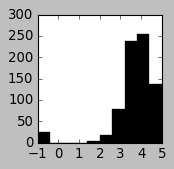

In [604]:

fig, ax = plt.subplots(1, figsize=(2, 2))
plt.style.use("seaborn-notebook")
plt.hist(df2["rating"], color="k")
plt.show()

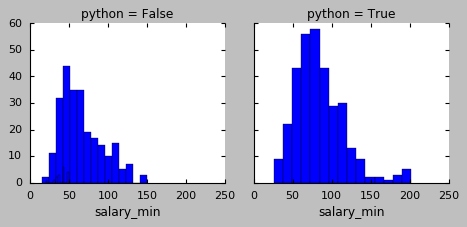

In [605]:
g = sns.FacetGrid(df2, col="python", hue="hourly")
g = g.map(plt.hist, "salary_min",bins=15, color="b")

In [606]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
boolean = ['bool']
categorical = ['object']
numeric_df = df2.select_dtypes(include=numerics)
boolean_df = df2.select_dtypes(include=boolean)
categorical_df = df2.select_dtypes(include=categorical)

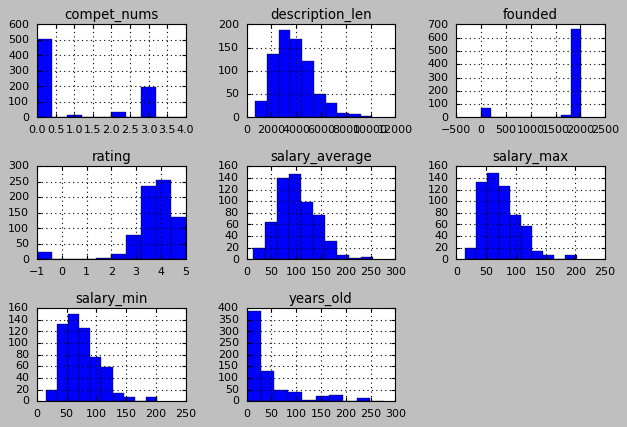

In [607]:
numeric_df.hist(color="b")
plt.tight_layout()
plt.show()

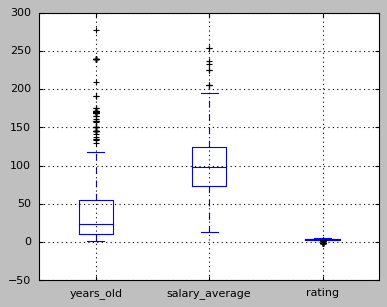

In [608]:
fig, ax = plt.subplots(1, figsize=(5, 4))
numeric_df[["years_old", "salary_average", "rating"]].boxplot(color="b")
plt.tight_layout()
plt.show()

In [609]:
numeric_df.corr()

,rating,founded,salary_average,salary_min,salary_max,years_old,description_len,compet_nums
rating,1.000000,0.467494,0.003109,-0.015034,-0.015034,-0.164578,-0.016731,0.010233
founded,0.467494,1.000000,-0.005909,-0.021799,-0.021799,-0.999995,0.105303,0.194682
salary_average,0.003109,-0.005909,1.000000,0.968731,0.968731,0.017793,0.054220,0.097298
salary_min,-0.015034,-0.021799,0.968731,1.000000,1.000000,0.005248,0.042275,0.082589
salary_max,-0.015034,-0.021799,0.968731,1.000000,1.000000,0.005248,0.042275,0.082589
years_old,-0.164578,-0.999995,0.017793,0.005248,0.005248,1.000000,0.143489,0.114711
description_len,-0.016731,0.105303,0.054220,0.042275,0.042275,0.143489,1.000000,0.163917
compet_nums,0.010233,0.194682,0.097298,0.082589,0.082589,0.114711,0.163917,1.000000


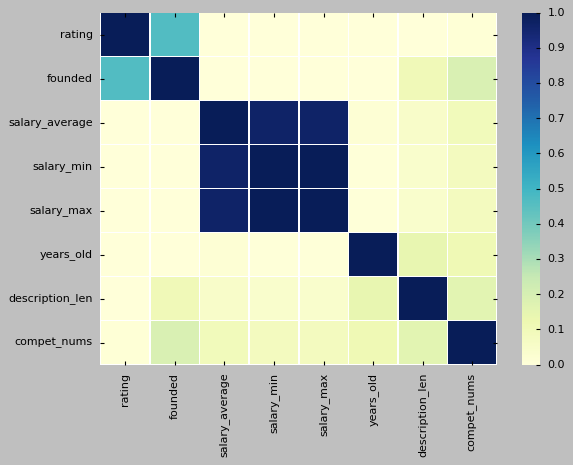

In [610]:
ax = sns.heatmap(numeric_df.corr(), cmap="YlGnBu",linewidths=.5, vmin=0, vmax=1)
plt.savefig("corr_plot.png", dpi=400)

In [611]:
categorical_df.head()

,job_title,salary_estimate,job_description,company_name,headquarters,size,type_of_ownership,industry,sector,revenue,competitors,city,state,parsed_num,company_txt,title_category,experience_level
0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\r\nLocation: Albuquerque, NM\r\...",Tecolote Research\r\n3.8,"Goleta, CA",501 to 1000 employees,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1,Albuquerque,NM,3.8,Tecolote Research,data scientist,NaN
1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\r\n\r\nI. General Summary\r\...,University of Maryland Medical System\r\n3.4,"Baltimore, MD",10000+ employees,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,Linthicum,MD,3.4,University of Maryland Medical System,data scientist,NaN
2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",KnowBe4\r\n4.8,"Clearwater, FL",501 to 1000 employees,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1,Clearwater,FL,"4, 4.8",KnowBe4,data scientist,NaN
3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\r\nJob ID: 310709\r...,PNNL\r\n3.8,"Richland, WA",1001 to 5000 employees,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa...",Richland,WA,3.8,PNNL,data scientist,NaN
4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\r\nAffinity Solutions / Marketi...,Affinity Solutions\r\n2.9,"New York, NY",51 to 200 employees,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee",New York,NY,2.9,Affinity Solutions,data scientist,NaN


In [612]:
x=categorical_df["state"].value_counts().index
y=categorical_df["state"].value_counts().values

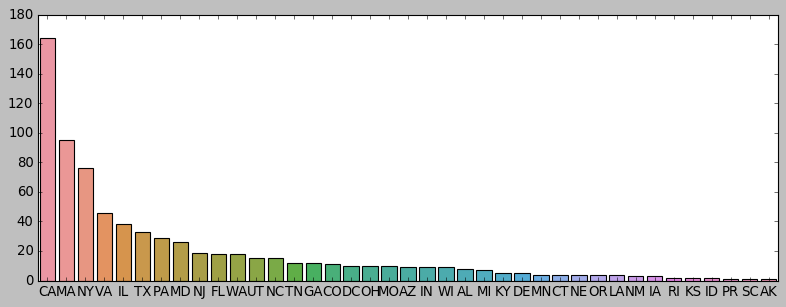

In [613]:
plt.style.use("classic")
fig, ax = plt.subplots(1, figsize=(10, 4))
sns.barplot(x,y)
plt.tight_layout()
plt.show()

In [614]:
# how to generate multiple bars?

v=categorical_df["title_category"].value_counts().index
z=categorical_df["title_category"].value_counts().values
xx = np.arange(6)
extra_y=z*1.2 
labels_xx = ["", 'data scientist', 'data engineer', 'analyst', 'manager', 'ML',
       'director', ""]

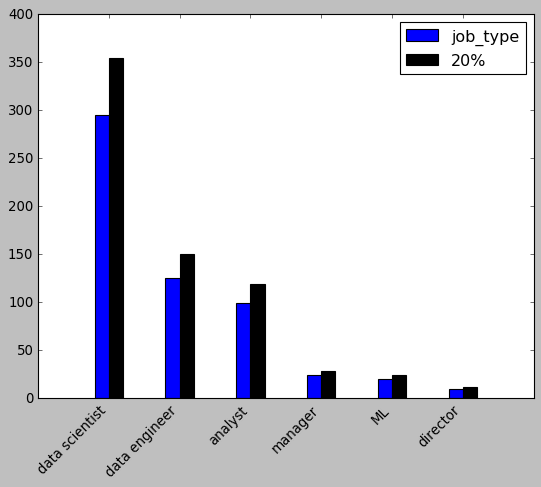

In [615]:
ax = plt.subplot()
ax.bar(xx-0.1, z, width=0.2, color='b', align="center", label="job_type")
ax.bar(xx+0.1, extra_y, width=0.2, color='k', align="center", label="20%")
ax.set_xticklabels(labels_xx, rotation=45, fontsize=12,ha="right")
ax.legend()
plt.rcParams["figure.figsize"] = (5,5)
plt.xlim(-1, 6)
plt.show()

In [616]:
series_z = pd.Series(z)
series_z2 =pd.Series(extra_y)
df_bar=pd.DataFrame({"S1":series_z, "S2":series_z2})

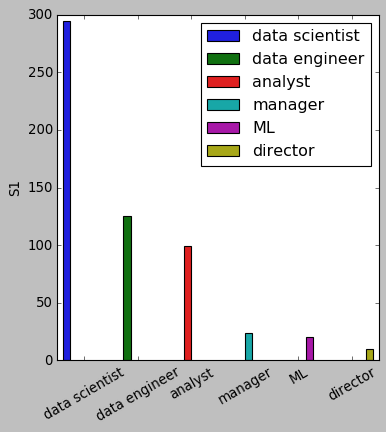

In [617]:
sns.barplot(x=v, hue=v, y="S1", data=df_bar)
plt.tight_layout()
plt.xticks(rotation="30", fontsize=12)
plt.rcParams["figure.figsize"] = (3,3)

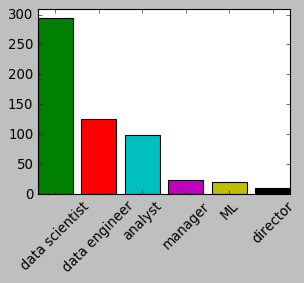

In [618]:
plt.style.use("classic")
fig, ax = plt.subplots(1, figsize=(4, 3))
plt.bar(v,z, color=["C1", "C2", "C3", "C4", "C5", "C6"])
plt.tight_layout()

plt.ylim(0, 310)
plt.xticks(rotation=45, fontsize=12)
plt.show()


Text(0.0, 0.55, 'Number of Positions Advertised')

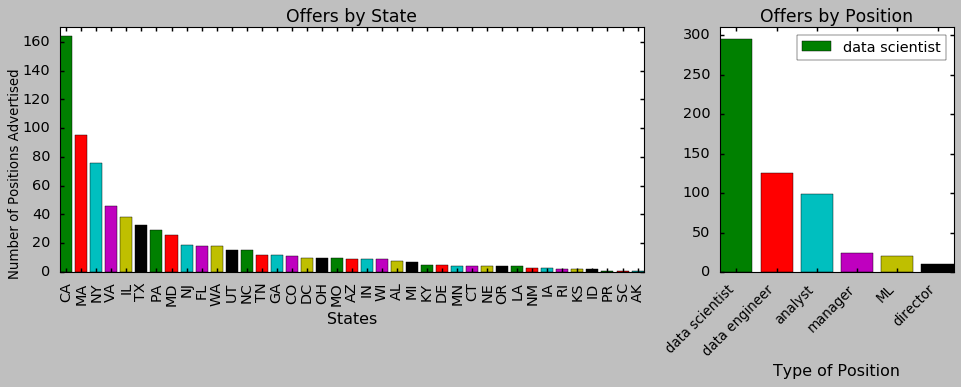

In [619]:
labels_ax2 = categorical_df["title_category"].value_counts().index
widths = [5, 2]
heights = [2]
gs_kw = dict(width_ratios=widths, height_ratios=heights, hspace=0)

plt.style.use("seaborn-talk")

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=gs_kw)
ax1.bar(x,y, color=["C1", "C2", "C3", "C4", "C5", "C6"])
ax1.set(ylim=(0,170), xlabel="States")
ax1.set_title("Offers by State")

for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
ax2.bar(v,z, color=["C1", "C2", "C3", "C4", "C5", "C6"])
ax2.set_xticklabels(labels_ax2, rotation=45, fontsize=12,ha="right")
ax2.set(ylim=(0,310), xlabel="Type of Position")
ax2.set_title("Offers by Position")
ax2.legend(labels_ax2, bbox_to_anchor=(1, 1), loc= "best") # legend?
plt.tight_layout()
fig.text(0.0, 0.55,"Number of Positions Advertised", va='center', rotation='vertical', fontsize=12)
# fig.savefig("bar_subplots_ax1_ax2", dpi=400)


In [620]:
(categorical_df["title_category"].value_counts().values)*1.2

array([354. , 150. , 118.8,  28.8,  24. ,  12. ])

In [621]:
categorical_df["title_category"].value_counts().index

Index(['data scientist', 'data engineer', 'analyst', 'manager', 'ML',
       'director'],
      dtype='object')

In [642]:
categorical_df_simplif = categorical_df[["size", "sector", "industry", "state", "title_category"]]

graph for size: total = 9


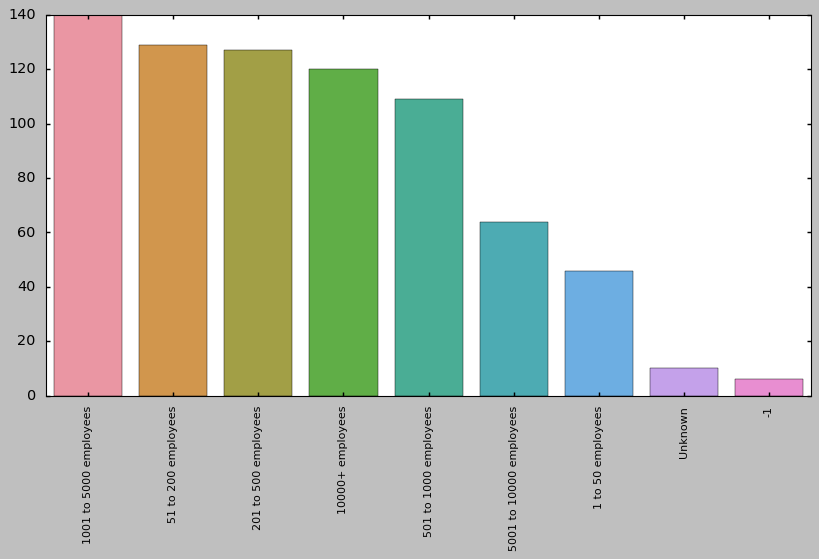

graph for sector: total = 25


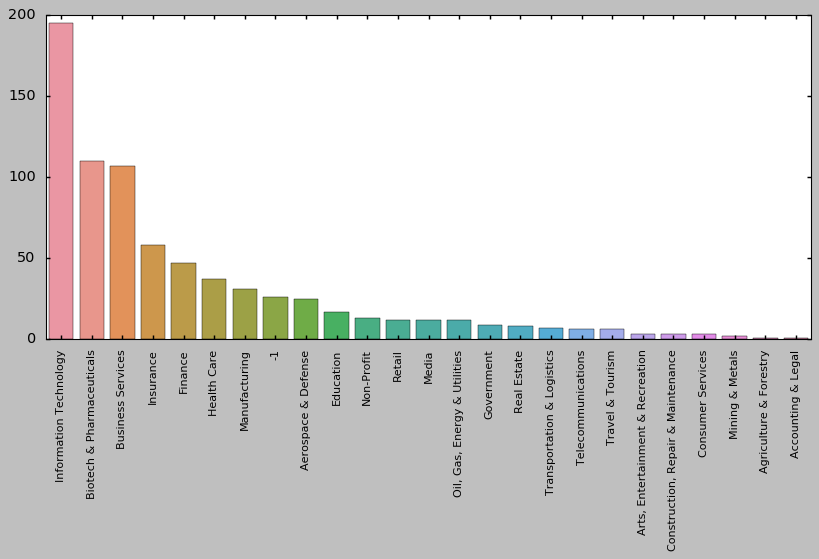

graph for industry: total = 62


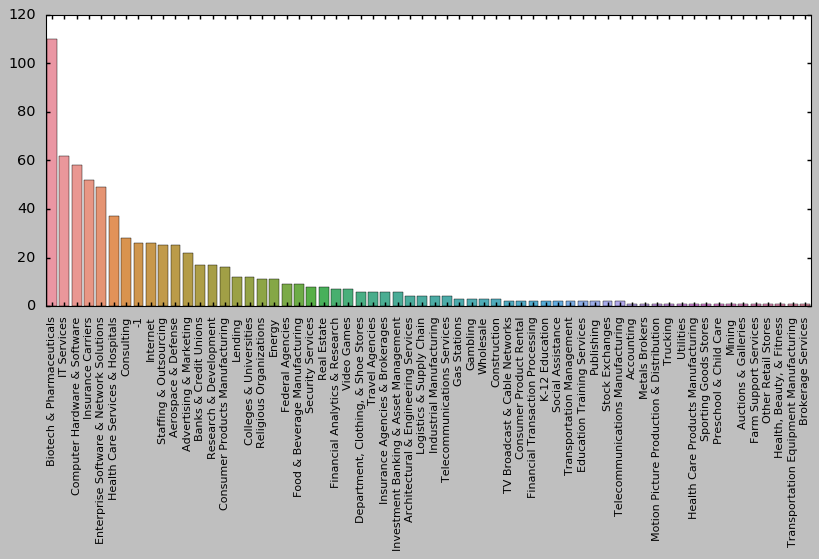

graph for state: total = 39


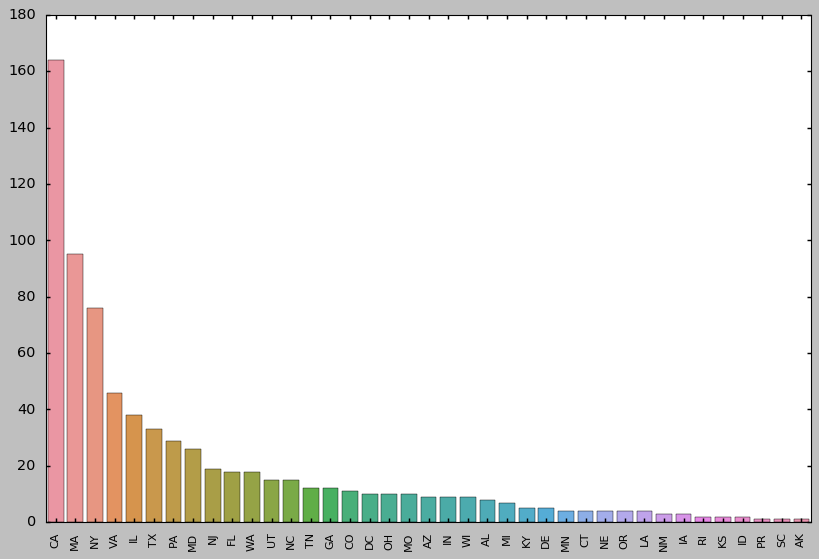

graph for title_category: total = 6


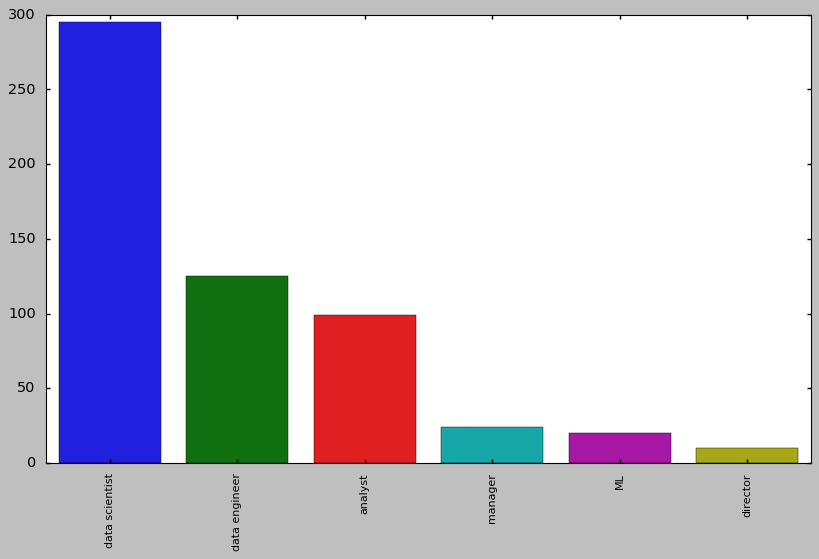

In [643]:
for i in categorical_df_simplif.columns:
    f=sns.barplot(x=categorical_df_simplif[i].value_counts().index, y=categorical_df_simplif[i].value_counts().values)
    print("graph for %s: total = %d" %(i, len(categorical_df_simplif[i].value_counts().index)))
    f.set_xticklabels(categorical_df_simplif[i].value_counts().index, rotation=90, fontsize=10)
    plt.tight_layout()
    plt.show()
